In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
#sys.path.insert(0, '/Users/gbromley/code/python_functions')
#import python_functions

In [2]:
data_dir = '/Volumes/ATLAS/reanalysis/'
nc_temp_file = 'NA_2m_temp_1900-2010.nc'
nc_dewp_file = 'NA_dwpt_2m_1900-2010.nc'
months = pd.date_range('1900-01-01','2010-12-01',freq='MS')

In [3]:
#load nc file
nc_temp = xr.open_dataset(data_dir+nc_temp_file)
temp = nc_temp['t2m']

nc_dewp = xr.open_dataset(data_dir+nc_dewp_file)
dewp = nc_dewp['d2m']

In [4]:
t_season='JJA'
t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2010-12-01'
ext_e = -90
ext_w = -120
ext_n = 55
ext_s = 30


In [5]:
def is_season(month):
    return (month >= 6) & (month <= 8)


def rel_hum(tk, tdk):
    tc = tk-273.15
    tdc = tdk-273.15
    e = 0.611*np.exp((17.27*tdc/(237.3+tdc)))
    es = 0.611*np.exp((17.27*tc/(237.3+tc)))
    #et = 0.611*np.exp((17.27*tdc/(237.3+tdc))
    return(100.0*(e/es))


In [6]:
test = map(rel_hum,temp.values, dewp.values)

relh = list(test)

In [ ]:
temp.time

In [7]:
dr_relh = xr.DataArray(relh, coords=[temp.time,temp.latitude,temp.longitude],dims=['time','latitude','longitude'], name='relh')


In [ ]:
dr_relh

In [ ]:
dr_relh.dims

In [ ]:

dr_relh[0,0,0]

In [ ]:
test_4

In [8]:
relh_1950=dr_relh.sel(time=slice(start_year,end_year))
#season_1950 = temp_1950.sel(time=temp_1950['time.month']==t_months)
season_1950 = relh_1950.sel(time=is_season(relh_1950['time.month']))
jja_1950 = season_1950.groupby('time.year').mean(dim='time')

clim_30= dr_relh.sel(time=slice('1981-01-01','2010-12-01'))
clim_months_30 = clim_30.sel(time=is_season(clim_30['time.month']))
jja_30 = clim_months_30.mean(dim='time')

In [ ]:
jja_30

In [9]:
spatial_trend = dr_relh.isel(time=1).copy(deep=True)
#pvalues= temp.isel(time=1).copy(deep=True)

In [10]:
for i in np.arange(0,len(dr_relh['latitude'])):
    for j in np.arange(0,len(dr_relh['longitude'])):
        series = jja_1950[:,i,j]
        anom = series-jja_30[i,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom)),anom)
        spatial_trend[i,j]=slope*10
        #pvalues[i,j]=p_value
        #print(i)


In [ ]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'spatial_trends_temp_'+t_season+'_'+start_year+'mtwb'+'.nc')

/Users/gbromley/anaconda/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


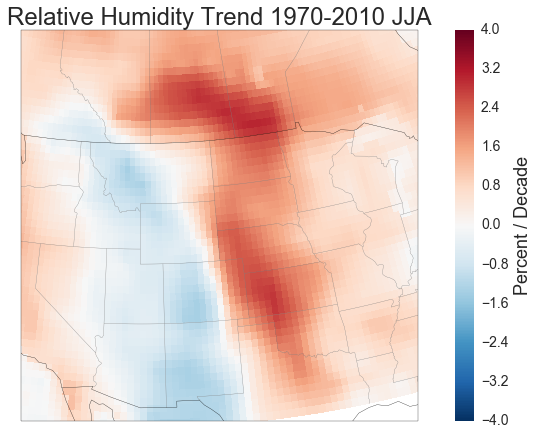

In [12]:
fig, ax = plt.subplots();
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax, transform=ccrs.PlateCarree(),vmin=-4, vmax=4, cmap='RdBu_r')
#ax = plt.axes(projection=ccrs.LambertConformal())

ax.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.title('Relative Humidity Trend 1970-2010 '+t_season,fontsize=24)
test.colorbar.set_label('Percent / Decade',fontsize=18)
test.colorbar.ax.tick_params(labelsize=14)
fig.set_size_inches(13,7)
fig.set_dpi=1200.0
plt.savefig('relh_spatial_'+t_season+'_1970.png')
plt.show()

In [ ]:
anom_series = jja_1950-jja_30.sel(season=t_season)
extent = anom_series.sel(latitude=np.arange(ext_s,ext_n,step=.5))
extent = extent.sel(longitude=np.arange(ext_w+360,ext_e+360,step=.5))
extent_series = extent.mean(dim=['latitude','longitude'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(extent_series)),extent_series.values)
line = slope*np.arange(0,len(extent_series.values))+intercept



fig, ax = plt.subplots();
plt.scatter(extent_series['year'],extent_series.values, c=extent_series.values,vmin=-3,vmax=2,cmap='RdBu_r',s=30);
#trend = ax.plot(anom['time'],line)
base = np.zeros(len(extent_series.values))
ax.plot(extent_series['year'],base,c='grey')
ax.set_title('North America 2m Temperature Anomaly '+t_season+' 1970-2010')
ax.set_xlabel('Year')
ax.set_ylabel('Temp Anomaly [C]')
trend = ax.plot(extent_series['year'],line)
#fig.savefig('2m_temp_anom_'+t_season+'_na_sp_1970.png')

